# Random Forestで機械学習の結果を解釈する

In [12]:
%matplotlib inline
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
df_date_data = pd.read_csv('../data/org/day.csv', header=0)
df_date_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [39]:
#今回使用するカラムに限定
used_columns = ['cnt', 'season', 'yr', 'mnth', 'holiday', 'weathersit', 'temp', 'hum', 'windspeed']
df = df_date_data.loc[:,used_columns]
df.head()

,cnt,season,yr,mnth,holiday,weathersit,temp,hum,windspeed
0,985,1,0,1,0,2,0.344167,0.805833,0.160446
1,801,1,0,1,0,2,0.363478,0.696087,0.248539
2,1349,1,0,1,0,1,0.196364,0.437273,0.248309
3,1562,1,0,1,0,1,0.200000,0.590435,0.160296
4,1600,1,0,1,0,1,0.226957,0.436957,0.186900


In [18]:
#特定のカラムに関して、ダミー変数を作成する

# ohe_columns = ['season', 'mnth', 'weathersit']
ohe_columns = ['weathersit']
df_ohe = pd.get_dummies(df, columns=ohe_columns)

In [40]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]
# X = df_ohe.iloc[:, 1:]
# y = df_ohe.iloc[:, 0]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

X.head()

,season,yr,mnth,holiday,weathersit,temp,hum,windspeed
0,1,0,1,0,2,0.344167,0.805833,0.160446
1,1,0,1,0,2,0.363478,0.696087,0.248539
2,1,0,1,0,1,0.196364,0.437273,0.248309
3,1,0,1,0,1,0.200000,0.590435,0.160296
4,1,0,1,0,1,0.226957,0.436957,0.186900


### RandomForest + feature importance

In [41]:
rf_model = RandomForestRegressor(n_estimators=100,random_state=50)
rf_model.fit(train_X, train_y)

pred_y = rf_model.predict(test_X)
score = sqrt(mean_squared_error(test_y, pred_y))

print('RMSE: {}'.format(score))

RMSE: 687.0233795079148


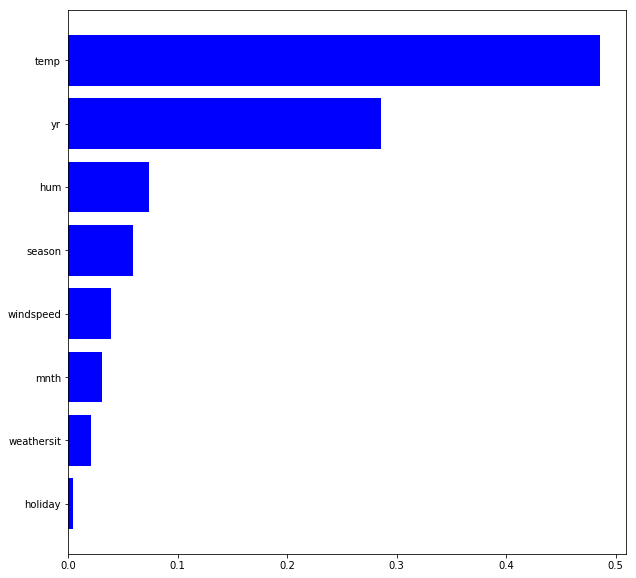

In [43]:
# feature importance
# tempの影響度がかなり大きい
features = df.columns[1:]
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

### Random Forest + Permutation Importance

In [61]:
# !pip install eli5
import eli5
from eli5.sklearn import PermutationImportance 
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler


scl = StandardScaler()
train_X = scl.fit_transform(train_X)
train_X = pd.DataFrame(train_X,columns=X.columns)


test_X = scl.fit_transform(test_X)
test_X = pd.DataFrame(test_X,columns=X.columns)
rf_model = Ridge(random_state=50)

rf_model.fit(train_X,train_y)

perm = PermutationImportance(rf_model, random_state=1).fit(train_X, train_y)
eli5.show_weights(perm, feature_names = train_X.columns.tolist())

Weight,Feature
0.5332 ± 0.0778,yr
0.5311 ± 0.0458,temp
0.1423 ± 0.0206,season
0.0372 ± 0.0108,weathersit
0.0357 ± 0.0058,windspeed
0.0200 ± 0.0043,hum
0.0045 ± 0.0041,holiday
0.0041 ± 0.0037,mnth


In [62]:
pred_y = rf_model.predict(test_X)
score = sqrt(mean_squared_error(test_y, pred_y))

print('RMSE: {}'.format(score))

RMSE: 931.832138218391


### Random Forest + Partial Dependence Plot

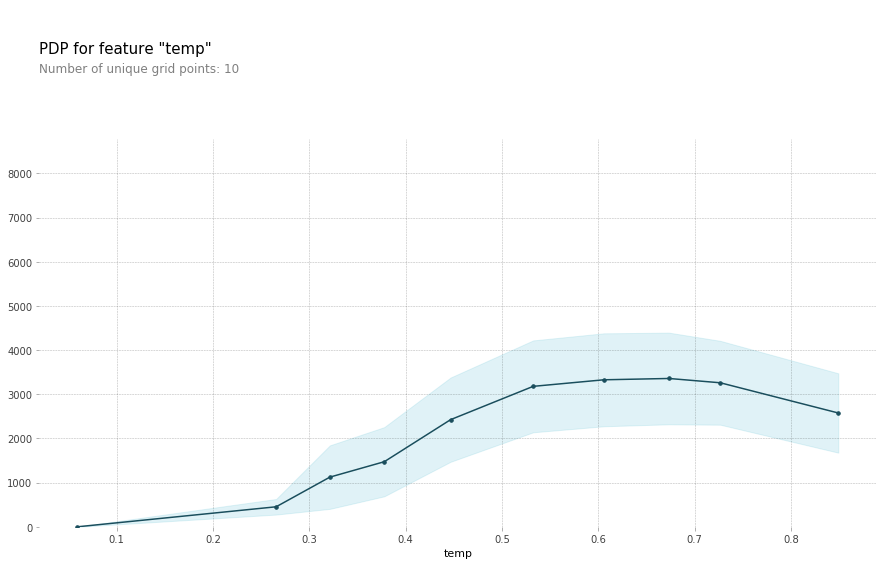

In [45]:
# !pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
features = train_X.columns.values
feature_to_plot = 'temp'
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=train_X[features], model_features=list(features), feature=feature_to_plot)

# PDPの実行
# データ自体が元から正規化されているためここでは具体的な値がわからないが傾向はつかめる
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

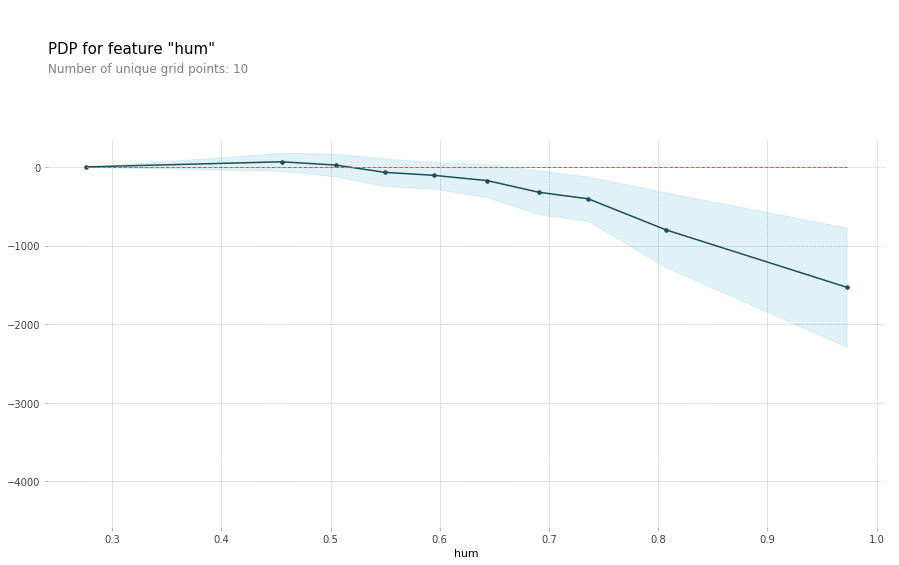

In [54]:
feature_to_plot = 'hum'
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=train_X[features], model_features=list(features), feature=feature_to_plot)

# PDPの実行
# データ自体が元から正規化されているためここでは具体的な値がわからないが傾向はつかめる
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

### Gradient Boosting

In [47]:
gb_model = GradientBoostingRegressor(n_estimators=100,random_state=50)
gb_model.fit(train_X, train_y)

pred_y = gb_model.predict(test_X)
score = sqrt(mean_squared_error(test_y, pred_y))

print('RMSE: {}'.format(score))

RMSE: 728.907024106403


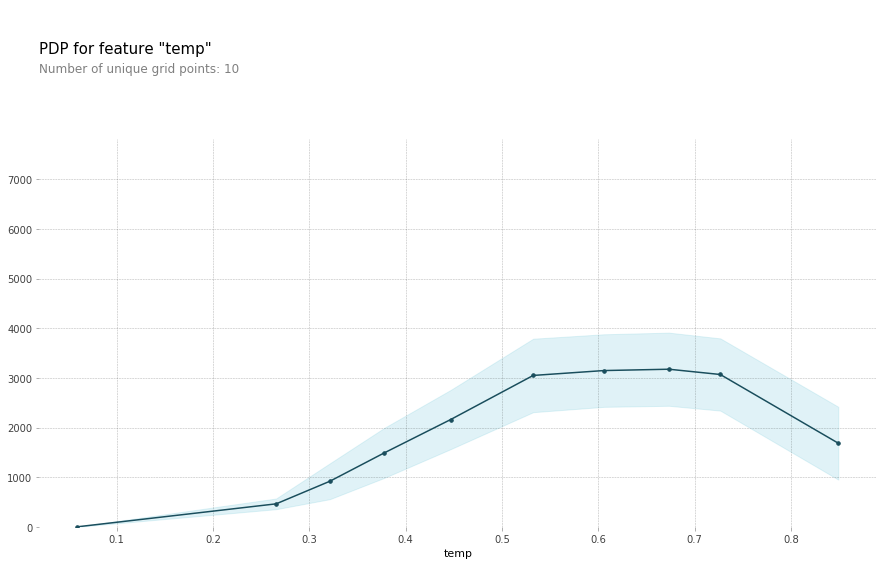

In [48]:
features = train_X.columns.values
feature_to_plot = 'temp'
pdp_goals = pdp.pdp_isolate(model=gb_model, dataset=train_X[features], model_features=list(features), feature=feature_to_plot)

# PDPの実行
# データ自体が元から正規化されているためここでは具体的な値がわからないが傾向はつかめる
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

In [52]:
print(len(df[df.temp > 0.7])/(len(df)))

0.17647058823529413


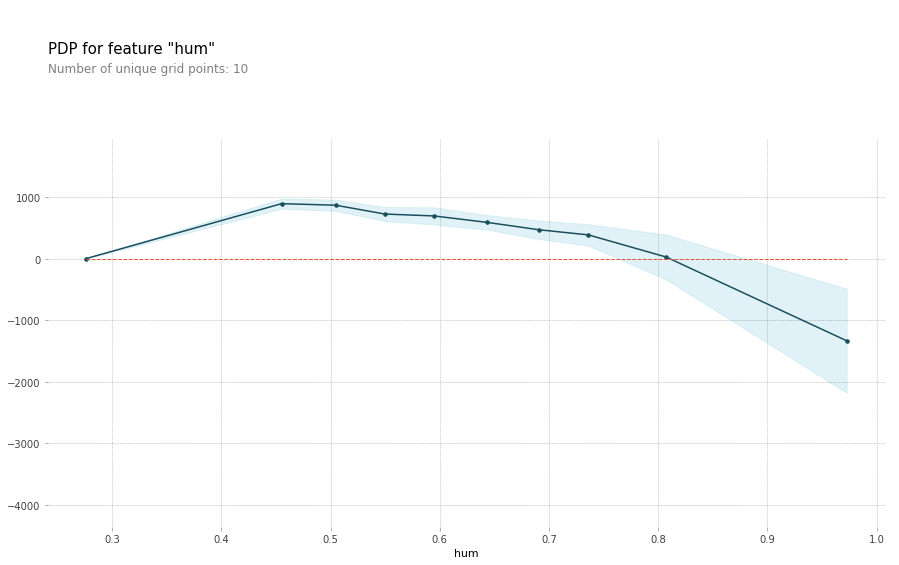

In [55]:
features = train_X.columns.values
feature_to_plot = 'hum'
pdp_goals = pdp.pdp_isolate(model=gb_model, dataset=train_X[features], model_features=list(features), feature=feature_to_plot)

# PDPの実行
# データ自体が元から正規化されているためここでは具体的な値がわからないが傾向はつかめる
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

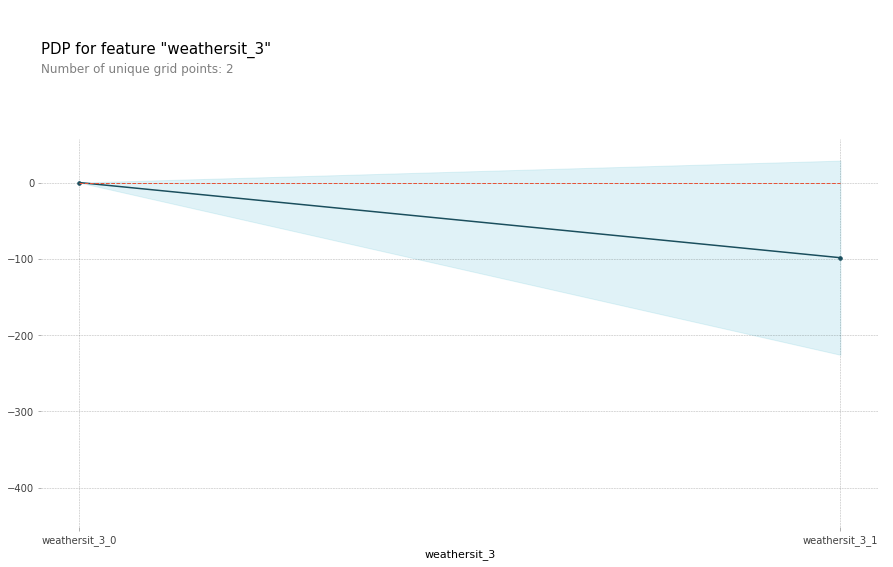

In [33]:
features = train_X.columns.values
feature_to_plot = 'weathersit_3'
pdp_goals = pdp.pdp_isolate(model=gb_model, dataset=train_X[features], model_features=list(features), feature=feature_to_plot)

# PDPの実行
# データ自体が元から正規化されているためここでは具体的な値がわからないが傾向はつかめる
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()